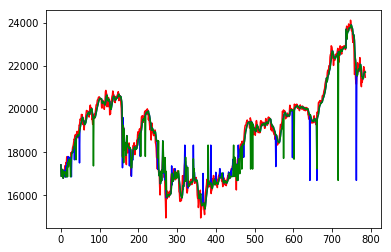

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime
import os
import yaml
from itertools import islice

from nupic.frameworks.opf.model_factory import ModelFactory

_NUM_RECORDS = 787
_INPUT_FILE_PATH = "C:\Users\mossa\Nupic_doc\kabuka.csv"
_PARAMS_PATH = "C:\Users\mossa\Nupic_doc\model.yaml"

x=np.array(range(_NUM_RECORDS))
#Nupicのmodelfactoryとモデルの中身を記述したyamlファイルを使ってOPFモデルを作成する

def createModel():
    with open(_PARAMS_PATH, "r") as f:
        modelParams = yaml.safe_load(f)
    return ModelFactory.create(modelParams)



def runHotgym(numRecords):
    model = createModel()
    #予測のデータを返却する
    model.enableInference({"predictedField": "consumption"})
    #配列の作成
    rawdata=[]
    result1data=[]
    result5data=[]
    with open(_INPUT_FILE_PATH) as fin:
        #ヘッダーの位置をスキップする
        reader = csv.reader(fin)
        headers = reader.next()
        reader.next()
        reader.next()
        results = []
        #itertoolsでループ処理
        for record in islice(reader, numRecords):
            #pythonの辞書形式でデータを読み込む
            #modelInputはgymdata.csvの形式から{'timestamp': '7/2/10 0:00', 'consumption': '21.2'}のような辞書になる
            modelInput = dict(zip(headers, record))
            modelInput["consumption"] = float(modelInput["consumption"])
            modelInput["timestamp"] = datetime.datetime.strptime(modelInput["timestamp"], "%Y/%m/%d")
            rawdata.append(modelInput["consumption"])
            #HTMの実行
            result = model.run(modelInput)
            #実行結果の取り出しを行う
            #multiStepBestPredictionsは最後のデータ行で返された最適な予測に関する情報(予測値)
            #multiStepPredictionsは各予測の信頼値を含む、データの最終行のすべての予測に関する情報(信頼値)
            bestPredictions = result.inferences["multiStepBestPredictions"]
            allPredictions = result.inferences["multiStepPredictions"]
            #1ステップ後の予測
            oneStep = bestPredictions[1]
            oneStepConfidence = allPredictions[1][oneStep]
            result1data.append(oneStep)
            #5ステップ後の予測
            fiveStep = bestPredictions[5]
            fiveStepConfidence = allPredictions[5][fiveStep]
            result5data.append(fiveStep)
            #予測値(信頼値)の形でprint
            result = (oneStep, oneStepConfidence * 100,fiveStep, fiveStepConfidence * 100)
            #予測値をprintしたい場合は下記のコメントアウトを外してください
            # print "1-step: {:16} ({:4.4}%)\t 5-step: {:16} ({:4.4}%)".format(*result)
            results.append(result)
        rawdata=np.array(rawdata)
        result1data=np.array(result1data)
        result5data=np.array(result5data)
    return results,rawdata,result1data,result5data


if __name__ == "__main__":
    data=runHotgym(_NUM_RECORDS)
    plt.plot(x,data[1],color="red")
    plt.plot(x,data[2],color="blue")
    plt.plot(x,data[3],color="green")